In [21]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.vision.all import *
from fastai.torch_core import defaults
from sklearn.model_selection import train_test_split
import torchvision.models as models

In [2]:
appa_data = pd.read_csv('appas_description.csv')
labels = pd.read_csv('labels.csv')

appa_data.head(3)

,Unnamed: 0,id,Город / Район,Микрорайон,Количество комнат,Тип аренды,Количество спальных мест,Общая площадь,Площадь кухни,Санузел,...,Студия,Ремонт,В новостройке,Метро,Возможен обмен,Товары с Куфар Оплатой,Есть проходная комната,Без мебели,Пешком до ближайшей станции,До ближайшей станции на транспорте
0,0,116057529,Московский,Малиновка,1,Долгосрочная,4.0,33 м²,8 м²,Раздельный,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,115563865,Советский,Сельхозпоселок,1,Долгосрочная,NaN,42 м²,NaN,Совмещенный,...,Да,Евро,Да,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,116054757,Центральный,NaN,1,Долгосрочная,NaN,NaN,NaN,Совмещенный,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
labels.head()

,Unnamed: 0,image,label
0,0,102560975_20.png,Junk
1,1,102560975_21.png,Junk
2,2,102560975_27.png,Bad
3,3,102560975_28.png,Bad
4,4,104480747_18.png,Good


<AxesSubplot:ylabel='label'>

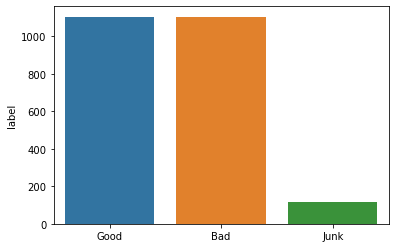

In [4]:
sns.barplot(labels.label.value_counts().index, labels.label.value_counts())

In [5]:
#Lets try to go with this imbalanced split

labels = labels[labels.label != 'Junk']
#labels = labels.merge(appa_data, how='left', on='id')
labels = labels[['image', 'label']]
labels.head(3)

,image,label
2,102560975_27.png,Bad
3,102560975_28.png,Bad
4,104480747_18.png,Good


In [6]:
labels.isna().sum()


image    0
label    0
dtype: int64

In [7]:
def get_x(df): return './TrainTestSplit/' + df.image
def get_y(df): return df.label

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                get_x = get_x,
                get_y = get_y,
                item_tfms = Resize(512),
                batch_tfms = aug_transforms(size=256, min_scale=0.75)
)

In [16]:
dls = dblock.dataloaders(labels, bs=4, num_workers=0)

In [15]:
torch.no_grad()

In [17]:
learn = cnn_learner(dls, resnet152, metrics=accuracy)
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy,time
0,0.668958,0.473025,0.773243,01:08
1,0.643346,0.432953,0.804989,01:06
2,0.486132,0.442773,0.811791,01:06


In [25]:
#resnet50 = 80% acc.
#try deeper model
torch.no_grad()
learn = cnn_learner(dls, xse_resnext50_deeper, metrics=accuracy)
learn.fine_tune(20, base_lr=3e-3, freeze_epochs=4)


epoch,train_loss,valid_loss,accuracy,time
0,0.721305,0.497441,0.773243,01:20
1,0.670925,0.475023,0.798186,01:20
2,0.676088,0.501806,0.759637,01:20
3,0.627708,0.506495,0.755102,01:21
4,0.628144,0.628007,0.693878,01:20
5,0.669613,0.517178,0.739229,01:21
6,0.646728,0.857752,0.641723,01:20
7,0.662084,0.507400,0.780045,01:20
8,0.630299,0.522605,0.761905,01:21
9,0.632124,0.505766,0.773243,01:20


In [27]:
learn.validate()

In [28]:
preds, targs = learn.get_preds()

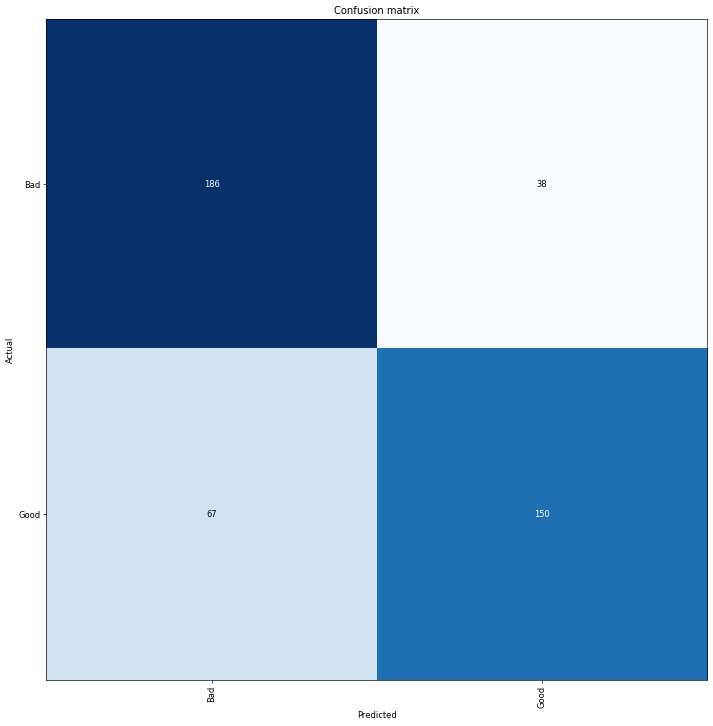

In [31]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


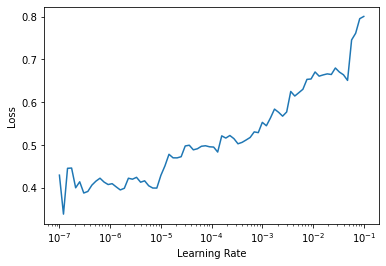

In [32]:
lr_min,lr_steep = learn.lr_find()

In [33]:
learn.fit_one_cycle(6, lr_max=1e-5)

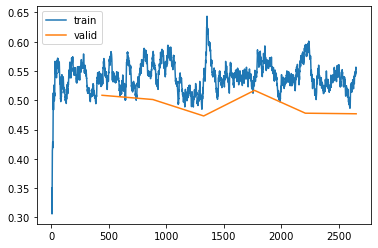

In [34]:
learn.recorder.plot_loss()

In [35]:
learn = cnn_learner(dls, resnet152, metrics=accuracy)
learn.fine_tune(5, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to C:\Users\Администратор/.cache\torch\hub\checkpoints\resnet152-b121ed2d.pth
100%|██████████| 230M/230M [01:34<00:00, 2.56MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.937430,39493.187500,0.473923,01:56
1,0.782198,22.654440,0.657596,01:56
2,0.759926,64.625877,0.637188,01:56
3,0.591517,20.286587,0.678005,01:56
4,0.603034,4.458875,0.750567,01:56


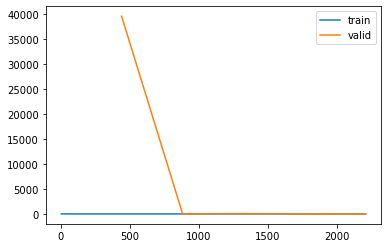

In [36]:
learn.recorder.plot_loss()

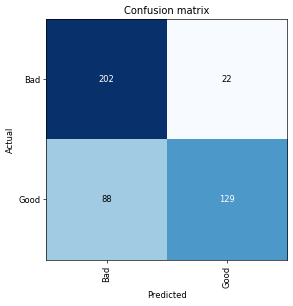

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)